## Welcome to my deliverable for the final project of 'How to win a Kaggle Comp.'
Let me guide you through a part of what I did for the final result. I did not include everything I did,
because a lot of it was not useful or did not work out the way I expected. Many things could be added, but due to private concerns I need to call it quits at this point. I may get back to this challenge at some point because I want to know how I can improve it, but for the time being, let this be all.

This notebook can be run just as any other notebook. The neural network will be slow without cuda, so you might want to refrain from actually running all of this on your machine.

I worked together with a teammate who copy pasted a lot of code from the internet which I had to track. If, for some code, I didn't mention the original poster I am sorry, I did what I could. When there is code from other people, this does not mean that I did not try to construct that code on my own, it just so happens that the code from others worked better than what I'd come up with, so I stuck with it.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import product
import re
from sklearn.preprocessing import LabelEncoder    
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.nn.modules import MSELoss
from torch.optim import Adam
import torch.nn.functional as F
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as rmse
from sklearn.linear_model import LinearRegression


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [2]:
# Load all the datasets

item_categories = pd.read_csv("./item_categories.csv")
items = pd.read_csv("./items.csv")
train = pd.read_csv("./sales_train.csv")
shops = pd.read_csv("./shops.csv")
test = pd.read_csv("./test.csv")
sample = pd.read_csv("./sample_submission.csv")

# Let us do some EDA first

In [3]:
print(len(shops))
display(shops)

# Looking through the shops we can see that shops 0 and 1 appear twice, as well as shop 10.

60


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [4]:
print(len(test['shop_id'].unique()))
display(shops[shops['shop_id'].isin(test['shop_id'].unique())])

# And when we look at the shops in the test data, we can see that they are gone.
# Because of this, we will change the shop ids from 0 to 57, 1 to 58 and 10 to 11 in the training set.

# We can also see that the names of the shops have several words in common. A quick search reveals that 
# ТЦ, ТРК, ТРЦ and ТК mean actually the same thing: Mall
# The word at the start is the name of the city where the shop is in.

42


,shop_name,shop_id
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
10,Жуковский ул. Чкалова 39м?,10
12,Интернет-магазин ЧС,12
14,"Казань ТЦ ""ПаркХаус"" II",14
15,"Калуга ТРЦ ""XXI век""",15


/home/skusku/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


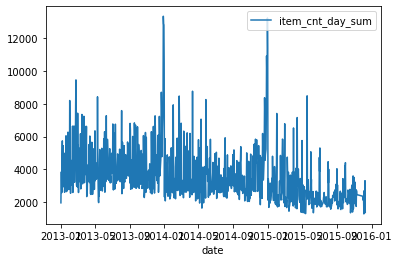

In [5]:
# Let's now have a look at the time series and see if we can find any trends

# For example we can plot the total number of sold items by all the shops together.
# First lets create timestamps from the dates for easier handling later.

train['date'] = pd.to_datetime(train['date'])
train['ts'] = train.date.values.astype(np.int64) // 10 ** 9
timeseries = train
groupby = train.groupby('date')['item_cnt_day']
timeseries = groupby.agg(item_cnt_day_sum=('item_cnt_day', 'sum'))
ax = sns.lineplot(data=timeseries)
display(ax)

         date  item_cnt_day_sum
0  2013-12-28           13343.0
1  2014-12-30           13236.0
2  2013-12-29           12863.0
3  2013-12-30           12823.0
4  2014-12-31           11394.0
5  2014-12-27           10919.0
6  2013-12-31           10514.0
7  2014-12-28            9727.0
8  2013-02-23            9456.0
9  2014-04-10            8767.0
10 2013-12-21            8704.0
11 2014-12-29            8593.0
12 2015-05-19            8483.0
13 2014-02-22            8472.0
14 2013-05-10            8425.0
15 2014-12-20            8367.0
16 2014-05-27            8256.0
17 2013-02-01            8198.0
18 2013-02-22            8009.0
19 2013-12-27            7991.0


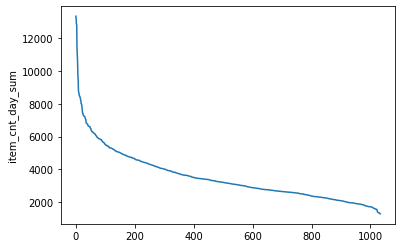

In [6]:
# The data seems to follow a certain trend, where there exist spikes at a certain interval.
# Let's find out what these intervals are:

timeseries_sorted = timeseries.sort_values(by='item_cnt_day_sum', ascending=False).reset_index()
print(timeseries_sorted.head(20))
ax = sns.lineplot(y='item_cnt_day_sum', x=timeseries_sorted.index, data=timeseries_sorted)
display(ax)

In [7]:
# We can thus see that the peaks supposedly happen around the end of the year. 
# Shops often do their inventory at the end of the year, so that is something to watch out for.
# In addition, christmas is around the end of the year where people buy a lot more stuff.
# We will add lagged variables to the training data in order to accomodate for these yearly spikes.

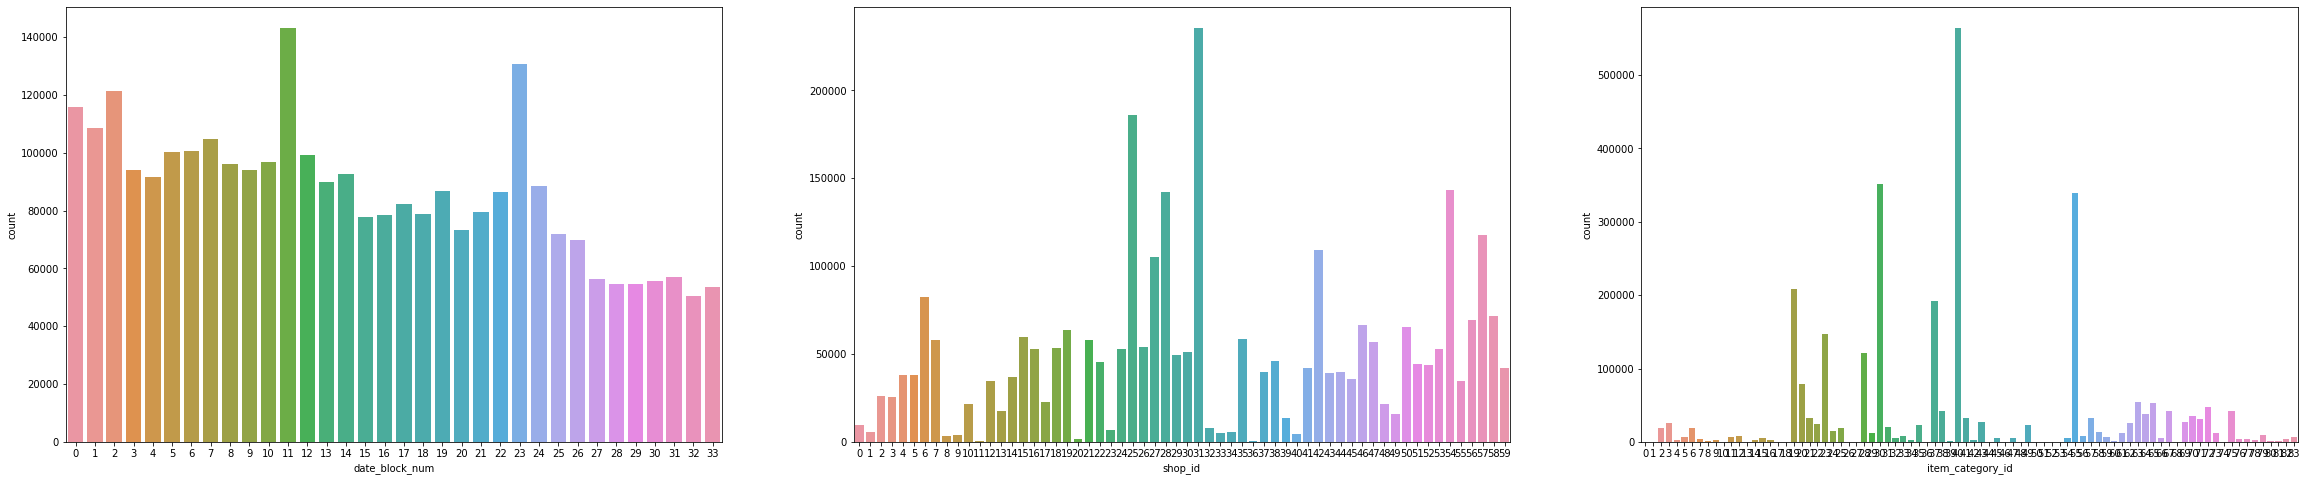

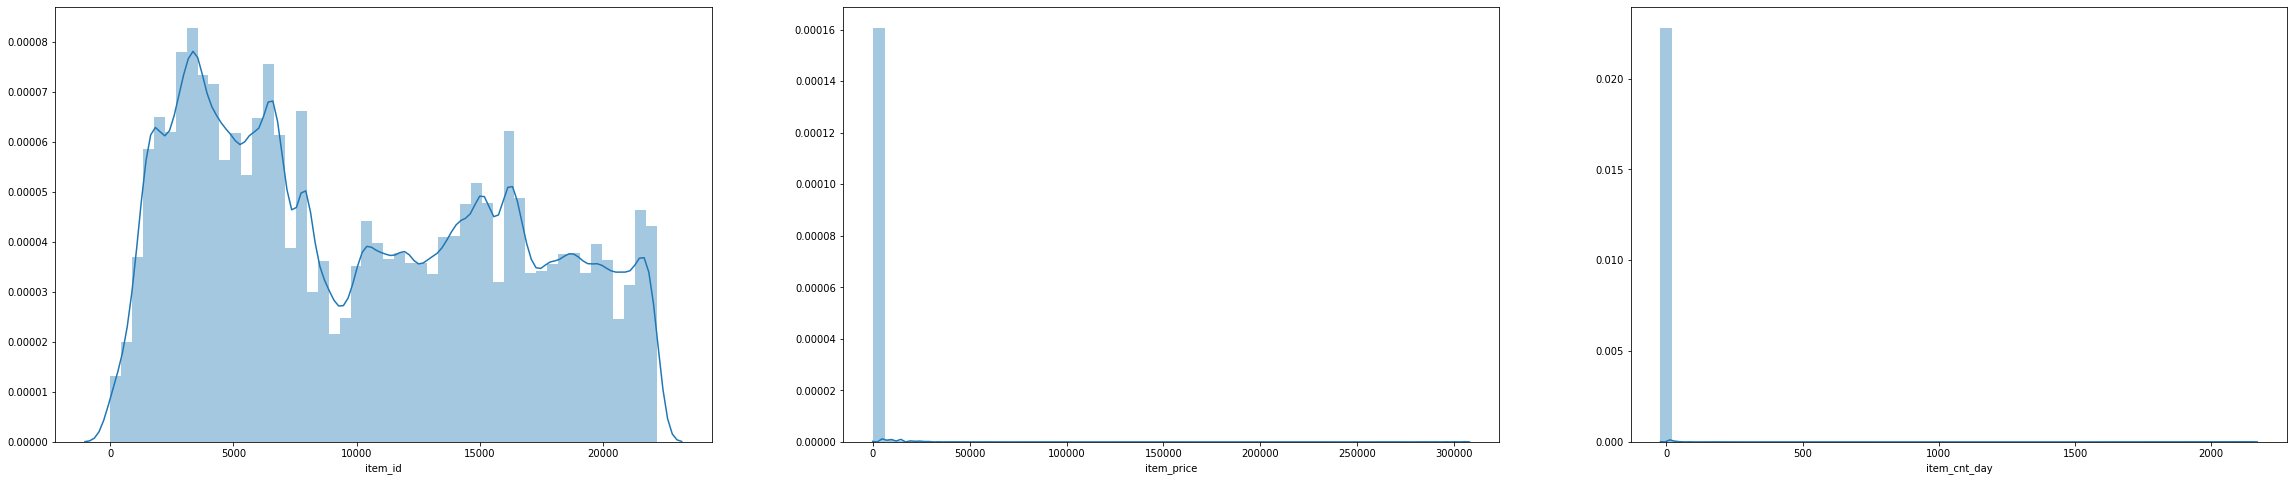

In [8]:
# Let's now have a look at the distributions of the data we know for sure from the test set, namely:
# date_block_num, shop_id and item_id.

# First: in the training set

fig, axs = plt.subplots(1, 3, figsize=(40,8))#, subplot_kw=dict(polar=True))

sns.countplot(x='date_block_num', data=train, ax=axs[0])
sns.countplot(x='shop_id', data=train, ax=axs[1])

merged = train.merge(items, on='item_id', how='left')
merged = merged.merge(item_categories, on='item_category_id', how='left')

sns.countplot(x='item_category_id', data=merged, ax=axs[2])

plt.show()

fig, axs = plt.subplots(1, 3, figsize=(40,8))
sns.distplot(train['item_id'], ax=axs[0])
sns.distplot(train['item_price'], ax=axs[1])
sns.distplot(train['item_cnt_day'], ax=axs[2])

plt.show()

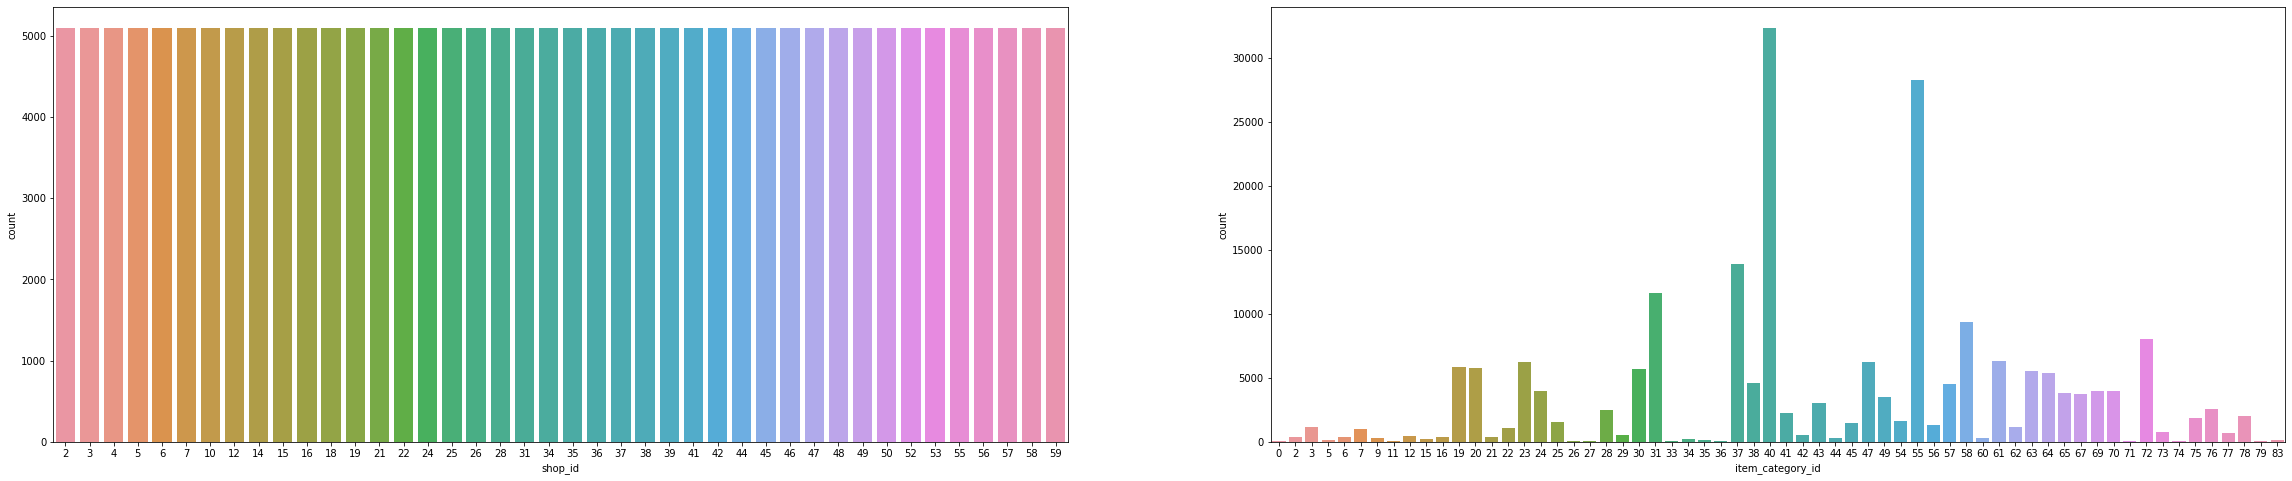

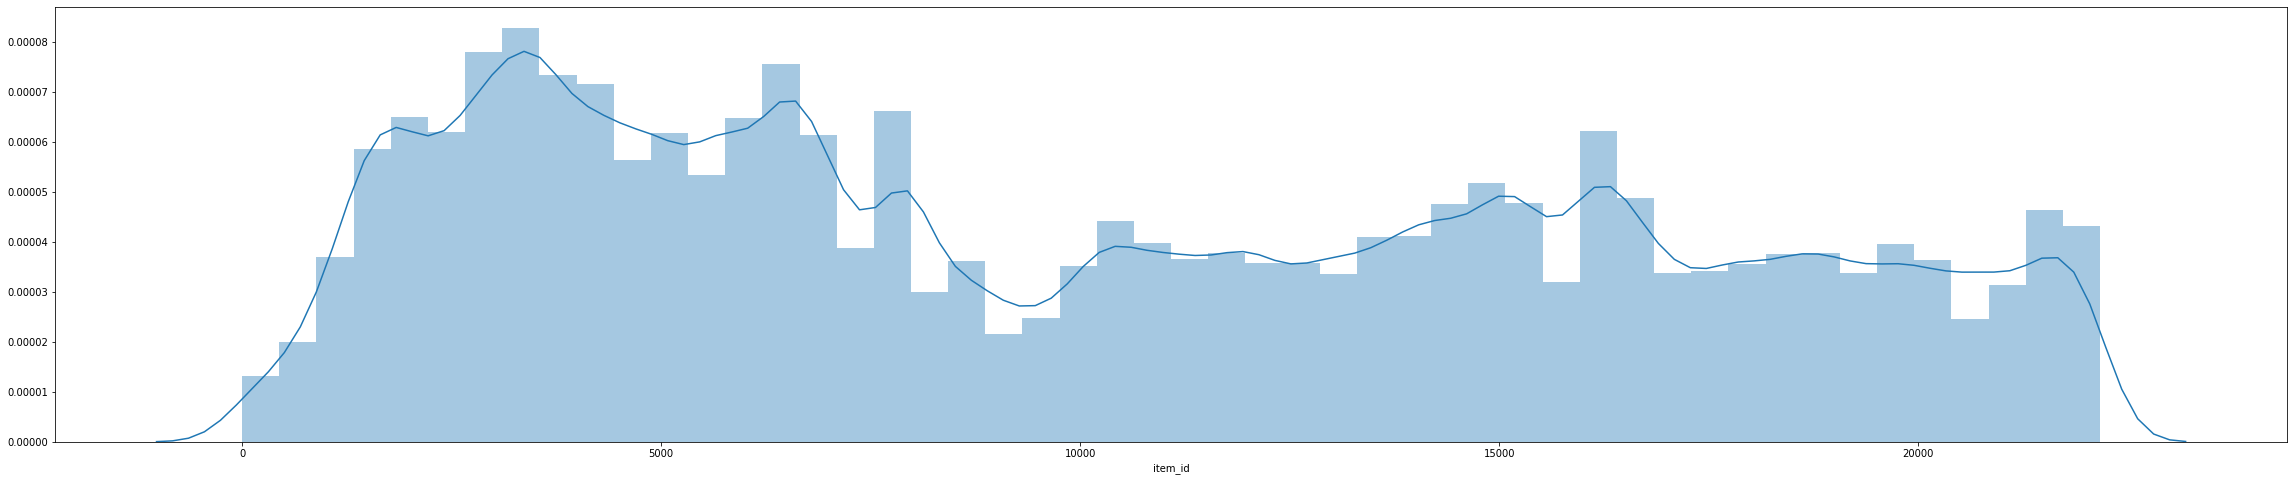

In [9]:
# Then look at similar data for the test set.

fig, axs = plt.subplots(1, 2, figsize=(40,8))#, subplot_kw=dict(polar=True))

sns.countplot(x='shop_id', data=test, ax=axs[0])

merged = test.merge(items, on='item_id', how='left')
merged = merged.merge(item_categories, on='item_category_id', how='left')

sns.countplot(x='item_category_id', data=merged, ax=axs[1])
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(40,8))
sns.distplot(train['item_id'], ax=axs)
plt.show()

In [10]:
# Wow! We can see that every shop_id is sampled the same amount of times. Let's look at how many times exactly
# And in the meantime, check a hypothesis too:

print("Total unique items: ", len(test['item_id'].unique()))
unique_shops = test['shop_id'].unique()

print([len(test.loc[test['shop_id'] == shop, 'item_id'].unique()) for shop in unique_shops])

# So we can see that the test set is probably the cartesian products between the shops and items that were seen
# in that month.
# This will help us tremendously by creating the validation set.

# Finally, let's see if the item_ids in the test set also all appear in the training set:

print("Is subset? {}".format(set(test['item_id'].unique()).issubset(set(train[train['date_block_num'] < 34]['item_id'].unique()))))
# No, they don't. So we will have to somehow notify our model of this.

Total unique items:  5100
[5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100]
Is subset? False


In [11]:
# Let's look at the item categories next
display(item_categories)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [12]:
# We can see that often times there is a hyphen in the name and that the first word occurs in many
# different item categories. We will use this to our advantage by splitting the categories in 
# main and sub categories later. A translation reveals that the data is mostly composed of electronics.

In [13]:
# Let's have a look at the items

display(items.head(100))

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [14]:
# We can see that a lot of the words are repeated. Without trying to translate them, we will just
# use some text processing tools to our disposal, such as Tfidf features.

## Data preprocessing and feature engineering
In order to get the most from our data, we have to do some preprocessing and feature engineering

In [15]:
# Because we think that this could be useful, we will gather data about
# oil prices, inflation and exchange rates for Rubel at the different months.
# We also rename the datasets because EDA and everything that follows were
# in different files at the time of development

oil_df = pd.read_csv('oil_prices.csv')
infl_df = pd.read_csv('inflation.csv')
exchange_df = pd.read_csv('exchange_df.csv')
raw_train = train
raw_test = test
shop_df = shops
item_df = items
item_cat_df = item_categories

In [16]:
# First we fix the shops and then remove the items and shops that are not in the test set.
# We deem them unhelpful for the task.

raw_train.loc[raw_train['shop_id'] == 0, 'shop_id'] = 57
raw_train.loc[raw_train['shop_id'] == 1, 'shop_id'] = 58
raw_train.loc[raw_train['shop_id'] == 11, 'shop_id'] = 10

train = raw_train[raw_train['item_id'].isin(raw_test['item_id'].unique())]
train = train[train['shop_id'].isin(raw_test['shop_id'].unique())]

In [17]:
# A function that we will use quite a lot and that we found from
# https://www.kaggle.com/c/champs-scalar-coupling/discussion/96655

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [18]:
# And use it right away

train = reduce_mem_usage(train)

Mem. usage decreased to 32.79 Mb (56.2% reduction)


In [19]:
# Now let us create the cartesian product of shops / items for every month that we talked about during EDA
# This code is in major parts taken directly from the course notebooks.

#Creating a dataframe for all possible combinations of shop_id, item_id, date_block_num in order to make it similar to
#the test set
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid.head()
grid.shape

#Getting the monthly sales dataframe by merging grid and train
sales_m = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).rename(columns={'item_cnt_day':'item_cnt_month'}).reset_index()

# Merging sales numbers with the grid dataframe
sales_m = pd.merge(grid,sales_m,on=['date_block_num','shop_id','item_id'],how='left')

# Fill the nan prices by first forward filling, then backward filling and then taking
# the maximum prize over all shops that sell this item in all months.
sales_m = sales_m.sort_values(by='date_block_num')
sales_m['item_price'] = sales_m.groupby(['shop_id', 'item_id'])['item_price'].ffill()
sales_m['item_price'] = sales_m.groupby(['shop_id', 'item_id'])['item_price'].bfill()
sales_m['item_price'] = sales_m['item_price'].fillna(sales_m.groupby('item_id')['item_price'].transform('max'))

In [20]:
# Now let us add the tfidf features from the item names. 
# The code for this is taken from https://www.kaggle.com/szhou42/predict-future-sales-top-11-solution

items_subset = item_df[['item_id', 'item_name']]
feature_count = 25
tfidf = TfidfVectorizer(max_features=feature_count)
items_df_item_name_text_features = pd.DataFrame(tfidf.fit_transform(items_subset['item_name']).toarray())

cols = items_df_item_name_text_features.columns
for i in range(feature_count):
    feature_name = 'item_name_tfidf_' + str(i)
    items_subset[feature_name] = items_df_item_name_text_features[cols[i]]

items_subset.drop('item_name', axis = 1, inplace = True)
item_df = item_df.merge(items_subset, on ='item_id', how ='left')

In [21]:
def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

# Create the main and sub categories from the item names
item_df['item_name'] = item_df['item_name'].apply(name_correction)
item_cat_df['new_cats'] = (item_cat_df['item_category_name']
                           .str.split(' - ').apply(lambda x: x[0]))
item_cat_df['new_subcats'] = (item_cat_df['item_category_name']
                           .str.split(' - ').apply(lambda x: x[-1]))

# Create the city names from the shop names as discussed above
shop_df['city'] = (shop_df['shop_name'].apply(name_correction)
                   .str.split(' ').apply(lambda x: x[0]))
shop_df.loc[shop_df['city']=='н', 'city'] = 'нижний_новгород'

# Also create the shop type from the shop names as discussed above
shop_df['shop_type'] = 'other'
mall_condition = ((shop_df['shop_name'].str.lower().str.contains('тц')) | (
    shop_df['shop_name'].str.lower().str.contains('трц')) | (shop_df['shop_name'].str.lower().str.contains('трк')) | (
                      shop_df['shop_name'].str.lower().str.contains('тк')))
shop_df.loc[mall_condition, 'shop_type'] = 'тц'
shop_df.loc[shop_df['shop_name'].str.lower().str.contains('склад'), 'shop_type'] = 'склад'

In [22]:
# Then merge the data with the main data
item_df = pd.merge(item_df, item_cat_df[['item_category_id', 'new_cats', 'new_subcats']])
item_df = item_df.rename(columns={'new_cats': 'item_category',
                                    'new_subcats': 'item_subcategory'})

sales_m = pd.merge(sales_m, item_df, how='left', on='item_id')

sales_m = pd.merge(sales_m, shop_df[['city', 'shop_type', 'shop_id']],how='left',on='shop_id')

In [23]:
# Using the code from https://gist.github.com/MLWhiz/8bc3cf1dc8887bde282983585de77acc
# we can create aggregated features over different groupings.

groupcollist = ['item_id', 'shop_id', 'item_category_id']

aggregationlist = [('item_price',np.mean,'avg'),('item_cnt_month',np.sum,'sum'),('item_cnt_month',np.mean,'avg')]

for type_id in groupcollist:
    for column_id,aggregator,aggtype in aggregationlist:
        # get numbers from sales data and set column names
        mean_df = sales_m.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']
        # merge new columns on sales_m data
        sales_m = pd.merge(sales_m,mean_df,on=['date_block_num',type_id],how='left')

In [24]:
# This useful function can be found at 
# https://github.com/anshul-shaive/Future-Sales-Prediction/blob/master/feature_engineering.py

def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [25]:
sales_new_df = sales_m.copy()

sales_new_df = sales_new_df.merge(oil_df,on='date_block_num',how='left')
sales_new_df = sales_new_df.merge(infl_df,how='left',on='date_block_num')
sales_new_df = sales_new_df.merge(exchange_df,how='left',on='date_block_num')

In [26]:
lag_variables  = ['item_id_avg_item_price', 'item_id_sum_item_cnt_month',
       'item_id_avg_item_cnt_month', 'shop_id_avg_item_price',
       'shop_id_sum_item_cnt_month', 'shop_id_avg_item_cnt_month',
       'item_category_id_avg_item_price',
       'item_category_id_sum_item_cnt_month',
       'item_category_id_avg_item_cnt_month','item_cnt_month']

In [27]:
# We will now impute the test rows into the dataframe.

test = raw_test.copy()
test['date_block_num'] = 34
test = pd.merge(test, item_df, how='left', on='item_id')
test = pd.merge(test, shop_df[['city', 'shop_type', 'shop_id']],how='left',on='shop_id')

extras = pd.merge(infl_df, oil_df, how='left', on='date_block_num')
extras = pd.merge(extras, exchange_df, how='left', on='date_block_num')
test = pd.merge(test, extras, how='left', on='date_block_num')

test = test.loc[:,~test.columns.duplicated()]
test = test.drop('ID',axis=1)
for col in lag_variables:
    test[col] = ' '

In [32]:
# And finally merge everything together to create the full dataset
full_df = pd.concat([sales_new_df, test])

# Fill the NaNs for the item prices of the test set. Forward filling alone does not work, so we will
# fill those items that we have seen already with their maximum price ever seen
# And if that doesn't work, we will fill with 0s.

full_df = full_df.sort_values(by='date_block_num')
full_df['item_price'] = full_df.groupby(['shop_id', 'item_id'])['item_price'].ffill()
full_df['item_price'] = full_df['item_price'].fillna(full_df.groupby('item_id')['item_price'].transform('max'))
full_df['item_price'] = full_df['item_price'].fillna(0)

# In order to communicate to the model that the price of 0 is not correct, we will add a feature
# that tells the model whether or not this item has been seen in the past.
# uniques = [full_df[full_df['date_block_num'] <= block]['item_id'].unique() for block in full_df['date_block_num'].unique()]
# full_df['seen_before'] = 0
# for i in range(1, len(uniques)):
#     # For every date_block_num, check if the item id is in the uniques of the previous month
#     full_df['seen_before'] = full_df['seen_before'].mask(full_df['date_block_num'] == i).fillna(full_df['item_id'].isin(uniques[i - 1]).astype(int))
    
full_df = full_df.reset_index(drop = True)
    
# Let's do the same things for every shop too. This is fairly slow.

all_views = None
for shop in tqdm(full_df['shop_id'].unique()):
    uniques = [full_df[(full_df['date_block_num'] == block) & (full_df['shop_id'] == shop)]['item_id'].unique() for block in full_df['date_block_num'].unique()]
    view = full_df.loc[full_df['shop_id'] == shop]
    view['seen_before_in_shop'] = 0
    
    for i in range(1, len(uniques)):
        view['seen_before_in_shop'] = view['seen_before_in_shop'].mask(view['date_block_num'] == i).fillna((view['item_id'].isin(uniques[i - 1]) | (view['seen_before_in_shop'])).astype(int))
        
    if all_views is None:
        all_views = view[['seen_before_in_shop', 'item_id', 'shop_id', 'date_block_num']]
    else:
        all_views = pd.concat([all_views, view[['seen_before_in_shop', 'item_id', 'shop_id', 'date_block_num']]])

full_df = full_df.merge(all_views, on=['item_id', 'shop_id', 'date_block_num'])
display(full_df.head())

full_df_index = full_df.index
# full_df = full_df.merge(oil_df[['date_block_num','change']],how='left',on='date_block_num').drop('change_x',axis=1)
full_df.tail()

/home/skusku/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


/home/skusku/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/skusku/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,change,city,date_block_num,inflation,item_category,item_category_id,item_category_id_avg_item_cnt_month,item_category_id_avg_item_price,item_category_id_sum_item_cnt_month,item_cnt_month,item_id,item_id_avg_item_cnt_month,item_id_avg_item_price,item_id_sum_item_cnt_month,item_name,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_2,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_price,item_subcategory,oil_price,rate,shop_id,shop_id_avg_item_cnt_month,shop_id_avg_item_price,shop_id_sum_item_cnt_month,shop_type,seen_before_in_shop
0,-0.0103,ярославль,0,0.97,Кино,37,1.80566,567,1103,1,22154,1.33301,919.5,16,явление 2012,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,999.0,Blu-Ray,358.92,30.0,59,2.2832,656.5,452,тц,0.0
1,-0.0103,ярославль,0,0.97,Игры,23,2.63281,1632,1103,3,3077,2.72656,1016.5,60,ea sports mma,0.0,0.665805,0.0,0.0,0.0,0.0,0.0,0.627255,0.404048,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1199.0,XBOX 360,358.92,30.0,59,2.2832,656.5,452,тц,0.0
2,-0.0103,ярославль,0,0.97,Игры,19,3.67578,1255,1088,1,3076,3.69531,1206,85,ea sports mma,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1399.0,PS3,358.92,30.0,59,2.2832,656.5,452,тц,0.0
3,-0.0103,ярославль,0,0.97,Игры,21,2.89258,746.5,454,5,2956,4.22266,572.5,114,disney pixar история игрушек большой побег,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.606187,0.0,0.0,0.0,0.0,0.0,0.795322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,575.0,PSP,358.92,30.0,59,2.2832,656.5,452,тц,0.0
4,-0.0103,калуга,0,0.97,Музыка,55,1.59668,254.875,3480,NaN,12541,1.16699,152,7,классика классика для релаксации 1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.0,CD локального производства,358.92,30.0,15,2.91797,656,636,тц,0.0


,change,city,date_block_num,inflation,item_category,item_category_id,item_category_id_avg_item_cnt_month,item_category_id_avg_item_price,item_category_id_sum_item_cnt_month,item_cnt_month,item_id,item_id_avg_item_cnt_month,item_id_avg_item_price,item_id_sum_item_cnt_month,item_name,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_2,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_price,item_subcategory,oil_price,rate,shop_id,shop_id_avg_item_cnt_month,shop_id_avg_item_price,shop_id_sum_item_cnt_month,shop_type,seen_before_in_shop
2953000,-0.062,москва,34,0.75,Игры,23,,,,,5232,,,,need for speed rivals,0.0,0.588259,0.0,0.0,0.0,0.0,0.0,0.554199,0.356989,0.0,0.0,0.000000,0.0,0.0,0.468373,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1199.0,XBOX 360,357.61,63.8312,21,,,,тц,1.0
2953001,-0.062,москва,34,0.75,Игры,20,,,,,5268,,,,need for speed,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.606187,0.0,0.0,0.000000,0.0,0.0,0.795322,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PS4,357.61,63.8312,21,,,,тц,0.0
2953002,-0.062,москва,34,0.75,Игры,23,,,,,5039,,,,nhl 15,0.0,0.727865,0.0,0.0,0.0,0.0,0.0,0.685721,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1499.0,XBOX 360,357.61,63.8312,21,,,,тц,1.0
2953003,-0.062,москва,34,0.75,Аксессуары,3,,,,,5672,,,,ps4 контроллер игровой беспроводной черный,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3590.0,PS4,357.61,63.8312,21,,,,тц,1.0
2953004,-0.062,самара,34,0.75,Кино,37,,,,,969,,,,3 дня на убийство,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.825666,0.0,0.0,0.000000,0.0,0.0,0.0,0.564159,0.0,0.0,0.0,0.0,0.0,0.0,549.0,Blu-Ray,357.61,63.8312,45,,,,тц,1.0


In [33]:
# We will now label encode the string values.

lb = LabelEncoder()
lb_cols = ['item_name','item_category','item_subcategory','city','shop_type']

for col in lb_cols:
    full_df[col + '_labels'] = lb.fit_transform(full_df[col])

full_df = full_df.drop(['item_name','item_category','item_subcategory','city','shop_type'], axis=1)

In [34]:
# And add the lag variables.

for i, lag in enumerate(lag_variables):
    print("Adding {}...{}/{}".format(lag, i + 1, len(lag_variables)))
    full_df = lag_feature(full_df,[1,2,3,4,5,12],lag)

Adding item_id_avg_item_price...1/10
Adding item_id_sum_item_cnt_month...2/10
Adding item_id_avg_item_cnt_month...3/10
Adding shop_id_avg_item_price...4/10
Adding shop_id_sum_item_cnt_month...5/10
Adding shop_id_avg_item_cnt_month...6/10
Adding item_category_id_avg_item_price...7/10
Adding item_category_id_sum_item_cnt_month...8/10
Adding item_category_id_avg_item_cnt_month...9/10
Adding item_cnt_month...10/10


In [35]:
# Add NaN values to the lag variables:
full_df = full_df.replace(' ',0)
for feat in full_df.columns:
    if 'item_cnt' in feat:
        full_df[feat]=full_df[feat].fillna(0)
    elif 'item_price' in feat:
        full_df[feat]=full_df[feat].fillna(full_df[feat].median())
    else:
        full_df[feat] = full_df[feat].fillna(full_df[feat].mean())

In [36]:
# Add exponentially weighted mean for the lag. This is an exponential running window mean
# for the several last months.

temp = full_df.sort_values('date_block_num').sort_values(['shop_id','item_id'])
temp['ewm_item_cnt_month_lag_1'] = temp.groupby(['shop_id', 'item_id'])['item_cnt_month_lag_1'].transform(lambda x: x.ewm(alpha=0.8, adjust=False).mean())

full_df = full_df.merge(temp[['ewm_item_cnt_month_lag_1']], left_index=True, right_index=True)

In [37]:
# Let's get rid of all the features that leak target data (except for item_cnt_month)
drop_cols = lag_variables[:-1] 

for col in drop_cols:
    del full_df[col]

In [38]:
# We will only consider the most recent data

mostly_full_df = full_df[full_df['date_block_num'] > 11]

In [40]:
# Add One Hot Encoded features - Didn't work well

# for col in oh_cols:
#     lb_col = col + '_labels'
#     onehot_encoded = pd.DataFrame(onehot_encoder.fit_transform(mostly_full_df[[lb_col]])).add_prefix(col + '_onehot_')
#     mostly_full_df = pd.concat([mostly_full_df, onehot_encoded], axis=1)

In [41]:
# These are functions to retrieve all the features that correspond to a certain encoding type.

def get_onehot_cols(df):
    onehot_c = [col for col in df.columns if not "labels" in col]
    
def get_label_cols(df):
    labels_c = [col for col in df.columns if not "onehot" in col]
    
def get_all_cols(df):
    return df.columns

In [42]:
# Choose the data
x_train = mostly_full_df[mostly_full_df['date_block_num']<33].drop('item_cnt_month',axis=1)
x_cv = mostly_full_df[mostly_full_df['date_block_num']==33].drop('item_cnt_month',axis=1)
x_train = reduce_mem_usage(x_train)
x_cv = reduce_mem_usage(x_cv)
y_train = mostly_full_df[mostly_full_df['date_block_num']<33]['item_cnt_month'].clip(0,20)
y_cv = mostly_full_df[mostly_full_df['date_block_num']==33]['item_cnt_month'].clip(0,20)

# And create the test input with accordance to the original file (We shuffled the columns a lot)
x_test = pd.merge(raw_test, full_df[full_df['date_block_num'] == 34], on=['item_id', 'shop_id'], how='left').drop(['item_cnt_month', 'ID'], axis=1)
x_test = x_test[x_train.columns]

Mem. usage decreased to 399.12 Mb (75.1% reduction)
Mem. usage decreased to 32.16 Mb (75.1% reduction)


In [44]:
# The first model is a simple neural network 

class NNModel(nn.Module):
    def __init__(self, n_features):
        super(NNModel, self).__init__()
        self.l1 = nn.Linear(n_features, 50)
        self.l2 = nn.Linear(50, 50)
        self.l3 = nn.Linear(50, 50)
        self.l4 = nn.Linear(50, 1)
        
        self.drop = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = F.relu(self.drop(self.l1(x)))
        x = F.relu(self.drop(self.l2(x)))
        x = F.relu(self.drop(self.l3(x)))
        x = self.l4(x)
        
        return x

nnmodel = NNModel(len(x_train.columns)).cuda()
criterion = MSELoss()
optimizer = Adam(nnmodel.parameters())

epochs = 20
batch_size = 64

# ONEHOT ENCODING IS DISABLED!!
fn = get_all_cols
onehot_x_train = x_train[fn(x_train)]
onehot_y_train = y_train
onehot_x_cv = x_cv[fn(x_cv)]
onehot_y_cv = y_cv
onehot_x_test = x_test[fn(x_test)]

x_train_tensor = torch.Tensor(onehot_x_train.values).type(torch.FloatTensor).cuda()
y_train_tensor = torch.Tensor(onehot_y_train.values).type(torch.FloatTensor).unsqueeze(-1).cuda()
x_cv_tensor = torch.Tensor(onehot_x_cv.values).type(torch.FloatTensor).cuda()
y_cv_tensor = torch.Tensor(onehot_y_cv.values).type(torch.FloatTensor).unsqueeze(-1).cuda()
x_test_tensor = torch.Tensor(onehot_x_test.values).type(torch.FloatTensor).cuda()

prev_validation_loss = np.infty

validation_predictions = []
test_predictions = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    nnmodel.train()
    losses = []
    batches = len(x_train) // batch_size
    
    for batch in tqdm(range(batches)):#zip(x_train.values, y_train.values), total=len(x_train)):
        X = x_train_tensor[batch * batch_size:(batch + 1) * batch_size]
        y = y_train_tensor[batch * batch_size:(batch + 1) * batch_size]
        
        optimizer.zero_grad()
        pred = nnmodel.forward(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    print("Average TRAIN loss: {}".format(sum(losses)/len(losses)))    
    
    nnmodel.eval()
    with torch.no_grad():
        losses = []
        batches = len(x_cv) // batch_size
        
        for batch in tqdm(range(batches)):
            X = x_cv_tensor[batch * batch_size:(batch + 1) * batch_size]
            y = y_cv_tensor[batch * batch_size:(batch + 1) * batch_size]
            
            pred = nnmodel.forward(X)
            loss = criterion(pred, y)
            losses.append(loss.item())
            
        print("Average VALIDATION loss: {}".format(sum(losses)/len(losses)))
        if prev_validation_loss < sum(losses) / len(losses):
            print("Validation loss rising, early stopping...")
            break
        prev_validation_loss = sum(losses) / len(losses)
        
validation_predictions.append(nnmodel.forward(x_cv_tensor).cpu().detach().numpy().clip(0, 20))
test_predictions.append(nnmodel.forward(x_test_tensor).cpu().detach().numpy().clip(0, 20))

del nnmodel
del x_train_tensor
del y_train_tensor
del x_cv_tensor
del y_cv_tensor
del x_test_tensor

torch.cuda.empty_cache()

validation_predictions[0] = np.reshape(validation_predictions[0], -1)
test_predictions[0] = np.reshape(test_predictions[0], -1)

Epoch: 0



Average TRAIN loss: 3.075259081445767



Average VALIDATION loss: 1.4011705326781336
Epoch: 1



Average TRAIN loss: 2.2362151400985373



Average VALIDATION loss: 1.3699665704846153
Epoch: 2



Average TRAIN loss: 2.1891208417528256



Average VALIDATION loss: 1.4068263716493268
Validation loss rising, early stopping...


[0]	validation_0-rmse:1.10571
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.03580
[2]	validation_0-rmse:1.00125
[3]	validation_0-rmse:0.98044
[4]	validation_0-rmse:0.97169
[5]	validation_0-rmse:0.96546
[6]	validation_0-rmse:0.96401
[7]	validation_0-rmse:0.95931
[8]	validation_0-rmse:0.95673
[9]	validation_0-rmse:0.95634
[10]	validation_0-rmse:0.95495
[11]	validation_0-rmse:0.95407
[12]	validation_0-rmse:0.95366
[13]	validation_0-rmse:0.95324
[14]	validation_0-rmse:0.95221
[15]	validation_0-rmse:0.95180
[16]	validation_0-rmse:0.94771
[17]	validation_0-rmse:0.94738
[18]	validation_0-rmse:0.94790
[19]	validation_0-rmse:0.95202
[20]	validation_0-rmse:0.95179
[21]	validation_0-rmse:0.95136
[22]	validation_0-rmse:0.95065
Stopping. Best iteration:
[17]	validation_0-rmse:0.94738

['item_id_sum_item_cnt_month_lag_1', 'item_name_tfidf_24', 'item_cnt_month_lag_4', 'shop_id_sum_item_cnt_month_lag_2', 'shop_id_sum_item_cnt_month_lag_1', 'shop_id_sum_item_cn

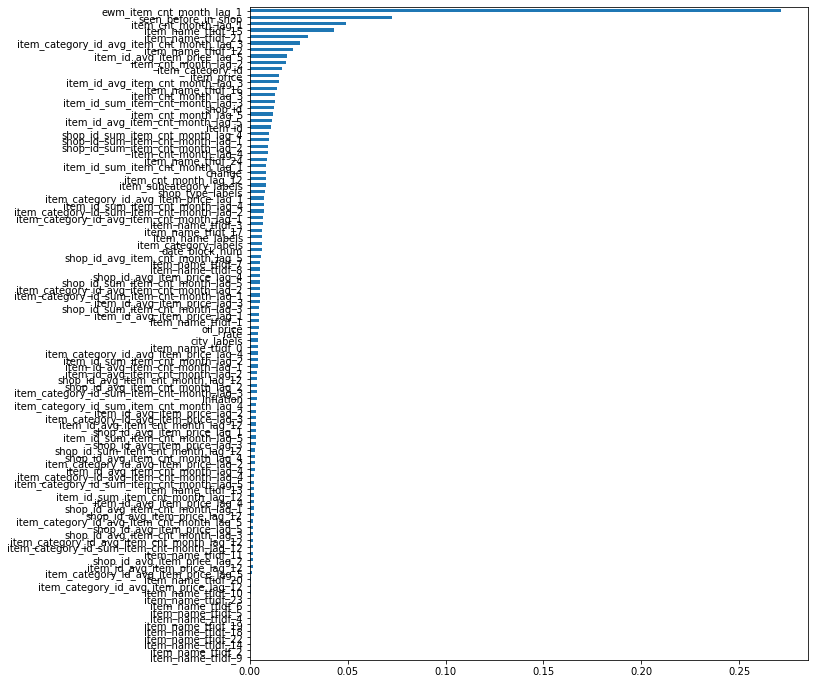

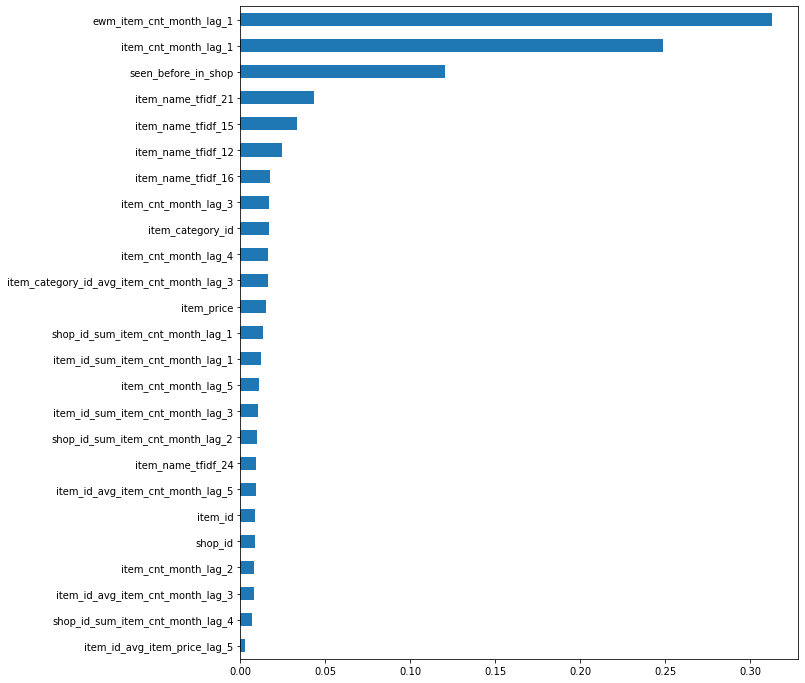

In [62]:
# Then follows an XGBoost regressor 


model_num = 1

xgb_featis = None

for i in range(model_num):
    if i == 0:
        fn = get_all_cols
    elif i == 1:
        fn = get_label_cols
    else:
        fn = get_onehot_cols
        
    current_x_train = x_train[fn(x_train)]
    current_y_train = y_train
    current_x_cv = x_cv[fn(x_cv)]
    current_y_cv = y_cv
    current_x_test = x_test[fn(x_test)]
    
    model = XGBRegressor(
        max_depth=8,
        n_estimators=100,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3, 
        seed=np.random.randint(500)
    )

    model.fit(current_x_train,current_y_train,eval_set=[(current_x_cv,current_y_cv)],early_stopping_rounds=5,verbose=True)
    # validation_predictions.append(model.predict(current_x_cv).clip(0, 20))
    # xgb_featis = model.predict(current_x_test).clip(0, 20)
    
    plt.figure(figsize=(10,12))
    ax = pd.Series(model.feature_importances_,index=current_x_train.columns).sort_values()
    ax.plot(kind='barh')
    
    most_important_features = [list(current_x_train.columns)[i] for i in list(np.argsort(model.feature_importances_)[-25:])]
    print(most_important_features)
    
    current_x_train = current_x_train[most_important_features]
    current_y_train = y_train
    current_x_cv = x_cv[most_important_features]
    current_y_cv = y_cv
    current_x_test = x_test[most_important_features]
    
    model.fit(current_x_train, current_y_train, eval_set=[(current_x_cv,current_y_cv)],early_stopping_rounds=5,verbose=True)
    
    plt.figure(figsize=(10,12))
    ax = pd.Series(model.feature_importances_,index=current_x_train.columns).sort_values()
    ax.plot(kind='barh')
    
    # validation_predictions.append(model.predict(current_x_cv).clip(0, 20))
    xgb_featis = model.predict(current_x_test).clip(0, 20)
    
    del model

In [46]:
# Create stage 2 predictions

validation_predictions = np.array(validation_predictions).T
test_predictions = np.array(test_predictions).T

stage2 = LinearRegression().fit(validation_predictions, y_cv)
prediction = stage2.predict(test_predictions).clip(0, 20)

In [63]:
# And produce the submission file

# submiss = pd.DataFrame({'ID':raw_test.index, 'item_cnt_month': prediction})
# submiss.to_csv('final_submission.csv',index=False)


submiss = pd.DataFrame({'ID':raw_test.index, 'item_cnt_month': xgb_featis})
submiss.to_csv('final_submission_only_xgb.csv',index=False)

In [48]:
display(current_x_train.sort_index().head())

,change,date_block_num,inflation,item_category_id,item_id,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_2,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_price,oil_price,rate,shop_id,seen_before_in_shop,item_name_labels,item_category_labels,item_subcategory_labels,city_labels,shop_type_labels,item_id_avg_item_price_lag_1,item_id_avg_item_price_lag_2,item_id_avg_item_price_lag_3,item_id_avg_item_price_lag_4,item_id_avg_item_price_lag_5,item_id_avg_item_price_lag_12,item_id_sum_item_cnt_month_lag_1,item_id_sum_item_cnt_month_lag_2,item_id_sum_item_cnt_month_lag_3,item_id_sum_item_cnt_month_lag_4,item_id_sum_item_cnt_month_lag_5,item_id_sum_item_cnt_month_lag_12,item_id_avg_item_cnt_month_lag_1,item_id_avg_item_cnt_month_lag_2,item_id_avg_item_cnt_month_lag_3,item_id_avg_item_cnt_month_lag_4,item_id_avg_item_cnt_month_lag_5,item_id_avg_item_cnt_month_lag_12,shop_id_avg_item_price_lag_1,shop_id_avg_item_price_lag_2,shop_id_avg_item_price_lag_3,shop_id_avg_item_price_lag_4,shop_id_avg_item_price_lag_5,shop_id_avg_item_price_lag_12,shop_id_sum_item_cnt_month_lag_1,shop_id_sum_item_cnt_month_lag_2,shop_id_sum_item_cnt_month_lag_3,shop_id_sum_item_cnt_month_lag_4,shop_id_sum_item_cnt_month_lag_5,shop_id_sum_item_cnt_month_lag_12,shop_id_avg_item_cnt_month_lag_1,shop_id_avg_item_cnt_month_lag_2,shop_id_avg_item_cnt_month_lag_3,shop_id_avg_item_cnt_month_lag_4,shop_id_avg_item_cnt_month_lag_5,shop_id_avg_item_cnt_month_lag_12,item_category_id_avg_item_price_lag_1,item_category_id_avg_item_price_lag_2,item_category_id_avg_item_price_lag_3,item_category_id_avg_item_price_lag_4,item_category_id_avg_item_price_lag_5,item_category_id_avg_item_price_lag_12,item_category_id_sum_item_cnt_month_lag_1,item_category_id_sum_item_cnt_month_lag_2,item_category_id_sum_item_cnt_month_lag_3,item_category_id_sum_item_cnt_month_lag_4,item_category_id_sum_item_cnt_month_lag_5,item_category_id_sum_item_cnt_month_lag_12,item_category_id_avg_item_cnt_month_lag_1,item_category_id_avg_item_cnt_month_lag_2,item_category_id_avg_item_cnt_month_lag_3,item_category_id_avg_item_cnt_month_lag_4,item_category_id_avg_item_cnt_month_lag_5,item_category_id_avg_item_cnt_month_lag_12,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_12,ewm_item_cnt_month_lag_1
511084,0.035889,12,0.589844,55,8169,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.728027,0.000000,0.0,0.685547,0.0,0.0,0.0,0.0,0.0,349.0,393.5,35.15625,55,1.0,1498,11,3,24,1,347.000,395.750,394.750,392.750,388.750,349.0,111.0,0.0,0.0,0.0,0.0,0.0,3.964844,0.0,0.0,0.0,0.0,0.0,867.5,863.0,811.5,788.5,752.5,711.5,726.0,0.0,0.0,0.0,0.0,0.0,6.660156,0.000000,0.000000,0.000000,0.000000,0.0,279.750,458.25,448.750,439.500,433.75,344.25,7108.0,0.0,0.0,0.0,0.0,0.0,1.874023,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
511085,0.035889,12,0.589844,31,508,0.491455,0.0,0.0,0.0,0.379883,0.0,0.0,0.0,0.346436,0.000000,0.566895,0.0,0.0,0.0,0.0,0.0,0.000000,0.415283,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,95.0,393.5,35.15625,55,1.0,79,7,48,24,1,98.875,98.875,98.875,98.875,98.875,349.0,1.0,1.0,1.0,1.0,4.0,0.0,1.000000,1.0,1.0,1.0,4.0,0.0,867.5,811.0,783.0,766.5,753.0,711.5,726.0,563.0,391.0,343.0,284.0,0.0,6.660156,5.746094,4.546875,3.988281,3.736328,0.0,334.000,356.75,339.500,339.000,312.00,344.25,332.0,285.0,208.0,202.0,178.0,0.0,4.488281,4.253906,3.250000,3.367188,2.871094,0.0,1.0,1.0,1.0,1.0,4.0,0.0,1.003906
511086,0.035889,12,0.589844,31,515,0.491455,0.0,0.0,0.0,0.379883,0.0,0.0,0.0,0.346436,0.000000,0.566895,0.0,0.0,0.0,0.0,0.0,0